In [1]:
import os
import SimpleITK as sitk
import numpy as np
import pandas as pd
import json

from matplotlib import pyplot as plt
%matplotlib inline 

from reader import ALL_PROTOCOLS, map_labels
test_csv = 'test.csv'

test_filenames = pd.read_csv(test_csv, 
                             dtype=object,
                             keep_default_na=False,
                             na_values=[]).as_matrix()
results = {}

In [2]:
def dice(predictions, labels, num_classes):
    """Calculates the categorical Dice similarity coefficients for each class
        between labels and predictions.
    Args:
        predictions (np.ndarray): predictions
        labels (np.ndarray): labels
        num_classes (int): number of classes to calculate the dice
            coefficient for
    Returns:
        np.ndarray: dice coefficient per class
    """

    dice_scores = np.zeros((num_classes))
    for i in range(num_classes):
        tmp_den = (np.sum(predictions == i) + np.sum(labels == i))
        tmp_dice = 2. * np.sum((predictions == i) * (labels == i)) / \
            tmp_den if tmp_den > 0 else np.nan
        dice_scores[i] = tmp_dice
    return dice_scores.astype(np.float32)

In [28]:
def evaluate2(config, test_filenames):
    
    protocols = config["protocols"]
    res = {}
    for i in range(len(test_filenames)):
        res_individual = {}
        for j in range(len(protocols)):

            subj_id = str(test_filenames[i][0])

            # Load the groud truth label
            idx = ALL_PROTOCOLS.index(protocols[j])
            lbl = sitk.GetArrayFromImage(
                sitk.ReadImage(str(test_filenames[i][2 + idx]))).astype(np.int32)
            
            lbl = map_labels(lbl, protocol=protocols[j])

            # Load the predicted segmentation
            seg_fn = os.path.join(config["out_segm_path"], subj_id, protocols[j] + '.nii.gz')
            seg = sitk.GetArrayFromImage(sitk.ReadImage(seg_fn)).astype(np.int32)

            seg = map_labels(seg, protocol=protocols[j])
            
            dscs =(dice(seg, lbl, config["num_classes"][j]))
            res_individual[protocols[j]] = dscs

        res[subj_id] = res_individual
        #print('ID={}; dscs={};'.format(subj_id, res[subj_id]))
    return res

def print_stats2(res, config):
    
    for p in config["protocols"]: 
        r = [np.nanmean(val[p][1:]) for val in res.values()]
        print('protocol: {}; mean: {:0.4f}; std: {:0.4f}; min: {:0.4f}; max: {:0.4f}'.format(
            p, np.mean(r), np.std(r), np.min(r), np.max(r)))

In [83]:
def evaluate(config, test_filenames):
    
    protocols = config["protocols"]
    res = {}
    for i in range(len(protocols)):
        res_protocol = {}
        for j in range(len(test_filenames)):
        
            subj_id = str(test_filenames[j][0])

            # Load the groud truth label
            idx = ALL_PROTOCOLS.index(protocols[i])
            lbl = sitk.GetArrayFromImage(
                sitk.ReadImage(str(test_filenames[j][2 + idx]))).astype(np.int32)
            
            lbl = map_labels(lbl, protocol=protocols[i])

            # Load the predicted segmentation
            seg_fn = os.path.join(config["out_segm_path"], subj_id, protocols[i] + '.nii.gz')
            seg = sitk.GetArrayFromImage(sitk.ReadImage(seg_fn)).astype(np.int32)

            seg = map_labels(seg, protocol=protocols[i])
            
            dscs = (dice(seg, lbl, config["num_classes"][i]))
            res_protocol[subj_id] = dscs

        res[protocols[i]] = res_protocol
        #print('ID={}; dscs={};'.format(subj_id, res[subj_id]))
    return res

def print_stats(res, config):
    
    for p in config["protocols"]: 
        r = [np.nanmean(val[1:]) for val in res[p].values()]
        print('protocol: {}; mean: {:0.4f}; std: {:0.4f}; min: {:0.4f}; max: {:0.4f}'.format(
            p, np.mean(r), np.std(r), np.min(r), np.max(r)))

In [84]:
# Parse the run config
cfg_fn = 'config_fsl_fast.json'
with open(cfg_fn) as f:
    cfg_fsl_fast = json.load(f)

# Evaluate and print stats
res_fsl_fast = evaluate(cfg_fsl_fast, test_filenames)
print_stats(res_fsl_fast, cfg_fsl_fast)

protocol: fsl_fast; mean: 0.9356; std: 0.0253; min: 0.7796; max: 0.9691


In [85]:
# Parse the run config
cfg_fn = 'config_fsl_first.json'
with open(cfg_fn) as f:
    cfg_fsl_first = json.load(f)

# Evaluate and print stats
res_fsl_first = evaluate(cfg_fsl_first, test_filenames)
print_stats(res_fsl_first, cfg_fsl_first)

protocol: fsl_first; mean: 0.9020; std: 0.0303; min: 0.5996; max: 0.9314


In [86]:
# Parse the run config
cfg_fn = 'config_malp_em.json'
with open(cfg_fn) as f:
    cfg_malp_em = json.load(f)

# Evaluate and print stats
res_malp_em = evaluate(cfg_malp_em, test_filenames)
print_stats(res_malp_em, cfg_malp_em)

protocol: malp_em; mean: 0.8725; std: 0.0262; min: 0.7131; max: 0.9082


In [87]:
# Parse the run config
cfg_fn = 'config_malp_em_tissue.json'
with open(cfg_fn) as f:
    cfg_malp_em_tissue = json.load(f)

# Evaluate and print stats
res_malp_em_tissue = evaluate(cfg_malp_em_tissue, test_filenames)
print_stats(res_malp_em_tissue, cfg_malp_em_tissue)

protocol: malp_em_tissue; mean: 0.9401; std: 0.0178; min: 0.8323; max: 0.9631


In [88]:
# Parse the run config
cfg_fn = 'config_spm_tissue.json'
with open(cfg_fn) as f:
    cfg_spm_tissue = json.load(f)

# Evaluate and print stats
res_spm_tissue = evaluate(cfg_spm_tissue, test_filenames)
print_stats(res_spm_tissue, cfg_spm_tissue)

protocol: spm_tissue; mean: 0.9327; std: 0.0445; min: 0.0623; max: 0.9602


In [90]:
# Parse the run config
cfg_fn = 'config_tissue.json'
with open(cfg_fn) as f:
    cfg_tissue = json.load(f)

# Evaluate and print stats
res_tissue = evaluate(cfg_tissue, test_filenames)
print_stats(res_tissue, cfg_tissue)

protocol: fsl_fast; mean: 0.9284; std: 0.0261; min: 0.7326; max: 0.9635
protocol: spm_tissue; mean: 0.9336; std: 0.0434; min: 0.0628; max: 0.9598
protocol: malp_em_tissue; mean: 0.9274; std: 0.0322; min: 0.6134; max: 0.9584


In [91]:
# Parse the run config
cfg_fn = 'config_all.json'
with open(cfg_fn) as f:
    cfg_all = json.load(f)

# Evaluate and print stats
res_all = evaluate(cfg_all, test_filenames)
print_stats(res_all, cfg_all)

protocol: fsl_fast; mean: 0.9306; std: 0.0242; min: 0.7367; max: 0.9652
protocol: fsl_first; mean: 0.8881; std: 0.0485; min: 0.2881; max: 0.9265
protocol: spm_tissue; mean: 0.9337; std: 0.0434; min: 0.0624; max: 0.9609
protocol: malp_em; mean: 0.8581; std: 0.0311; min: 0.5725; max: 0.8965
protocol: malp_em_tissue; mean: 0.9321; std: 0.0194; min: 0.7578; max: 0.9586


In [145]:
res_all

{'fsl_fast': {'5404127': array([ 0.99764174,  0.8875317 ,  0.90522665,  0.93169487], dtype=float32),
  '5405254': array([ 0.99768776,  0.92429066,  0.93732655,  0.94846869], dtype=float32),
  '5405293': array([ 0.9972288 ,  0.91838086,  0.95352727,  0.98258305], dtype=float32),
  '5406228': array([ 0.99739343,  0.89942843,  0.93974644,  0.94774252], dtype=float32),
  '5407257': array([ 0.9975574 ,  0.8555423 ,  0.90421283,  0.92566121], dtype=float32),
  '5407843': array([ 0.99791604,  0.91541308,  0.95887166,  0.97903919], dtype=float32),
  '5408063': array([ 0.99761808,  0.8904649 ,  0.95723557,  0.97284907], dtype=float32),
  '5410107': array([ 0.99756134,  0.90108812,  0.94975537,  0.96054542], dtype=float32),
  '5411328': array([ 0.99757516,  0.92009372,  0.96461046,  0.98268479], dtype=float32),
  '5411472': array([ 0.99732417,  0.87704164,  0.96015799,  0.97941691], dtype=float32),
  '5411938': array([ 0.9972108 ,  0.87888277,  0.92907435,  0.95306796], dtype=float32),
  '541456

In [181]:

hdr = ['id', 'dsc', 'protocol', 'net_type']

df = None
network_type = 'nn_all'
for protocol, res in res_all.items():
    for subj_id, dsc_list in res.items():
        current_df = pd.DataFrame(
            [[subj_id,
              np.nanmean(dsc_list[1:]),
              protocol, network_type]], columns=hdr)
        df = current_df if df is None else df.append(current_df, ignore_index=True)

network_type = 'nn_tissue'
for protocol, res in res_tissue.items():
    for subj_id, dsc_list in res.items():
        current_df = pd.DataFrame(
            [[subj_id,
              np.nanmean(dsc_list[1:]),
              protocol, network_type]], columns=hdr)
        df = current_df if df is None else df.append(current_df, ignore_index=True)
        
network_type = 'single'
for protocol, res in res_fsl_fast.items():
    for subj_id, dsc_list in res.items():
        current_df = pd.DataFrame(
            [[subj_id,
              np.nanmean(dsc_list[1:]),
              protocol, network_type]], columns=hdr)
        df = current_df if df is None else df.append(current_df, ignore_index=True)

for protocol, res in res_fsl_first.items():
    for subj_id, dsc_list in res.items():
        current_df = pd.DataFrame(
            [[subj_id,
              np.nanmean(dsc_list[1:]),
              protocol, network_type]], columns=hdr)
        df = current_df if df is None else df.append(current_df, ignore_index=True)

for protocol, res in res_malp_em.items():
    for subj_id, dsc_list in res.items():
        current_df = pd.DataFrame(
            [[subj_id,
              np.nanmean(dsc_list[1:]),
              protocol, network_type]], columns=hdr)
        df = current_df if df is None else df.append(current_df, ignore_index=True)

for protocol, res in res_malp_em_tissue.items():
    for subj_id, dsc_list in res.items():
        current_df = pd.DataFrame(
            [[subj_id,
              np.nanmean(dsc_list[1:]),
              protocol, network_type]], columns=hdr)
        df = current_df if df is None else df.append(current_df, ignore_index=True)

for protocol, res in res_spm_tissue.items():
    for subj_id, dsc_list in res.items():
        current_df = pd.DataFrame(
            [[subj_id,
              np.nanmean(dsc_list[1:]),
              protocol, network_type]], columns=hdr)
        df = current_df if df is None else df.append(current_df, ignore_index=True)

print(df)

           id       dsc    protocol net_type
0     5863977  0.864898     malp_em   nn_all
1     5563222  0.893334     malp_em   nn_all
2     5455568  0.886549     malp_em   nn_all
3     5727652  0.869550     malp_em   nn_all
4     5492160  0.879720     malp_em   nn_all
5     5939451  0.847336     malp_em   nn_all
6     5610023  0.818510     malp_em   nn_all
7     5994886  0.855275     malp_em   nn_all
8     5503133  0.859086     malp_em   nn_all
9     5648624  0.851553     malp_em   nn_all
10    5669375  0.784572     malp_em   nn_all
11    5827934  0.858335     malp_em   nn_all
12    5481920  0.871687     malp_em   nn_all
13    5817468  0.855466     malp_em   nn_all
14    5437170  0.868314     malp_em   nn_all
15    5786702  0.875633     malp_em   nn_all
16    6002075  0.785626     malp_em   nn_all
17    5495230  0.865478     malp_em   nn_all
18    5927579  0.872393     malp_em   nn_all
19    5983506  0.835585     malp_em   nn_all
20    5445090  0.876094     malp_em   nn_all
21    5659

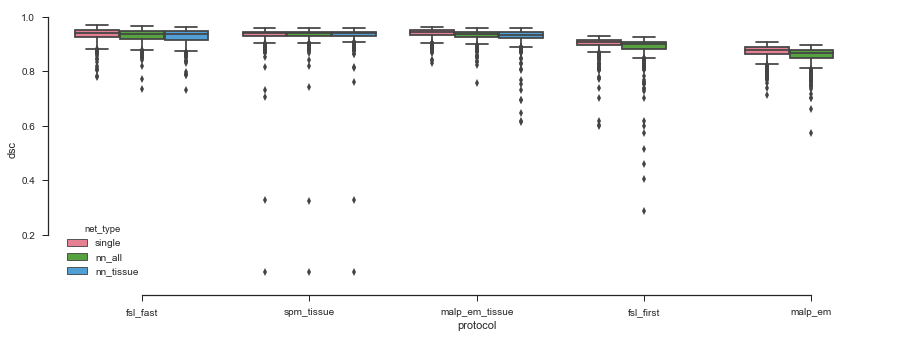

In [210]:
import seaborn as sns

fig, ax = plt.subplots(figsize=[15,5])
sns.set()
sns.set(style="ticks") 

sns.boxplot(ax=ax, x="protocol", y="dsc", hue="net_type", 
            hue_order=['single', 'nn_all', 'nn_tissue'],
            order=['fsl_fast', 'spm_tissue', 'malp_em_tissue', 'fsl_first', 'malp_em'],
            data=df, palette="husl")

sns.despine(offset=10, trim=True)